# Importing libraries and cleaned dataset

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler

**Original Dataset**:

Chen,Daqing. (2015). Online Retail. UCI Machine Learning Repository. https://archive.ics.uci.edu/dataset/352/online+retail

In [2]:
# Importing the cleaned dataset from my first notebook
file_path = '../data/data_cleaned.csv'
df = pd.read_csv(file_path, dtype={'InvoiceNo': 'O','StockCode': 'O','Description': 'O',
                                   'Quantity': 'int64','UnitPrice': 'float64',
                                   'CustomerID': 'Int64','Country': 'O'}, parse_dates=['InvoiceDate'])

# Filtering the dataset

Based on the initial analysis conducted in previous notebooks, I have made some preliminary decisions regarding data filtering. These decisions include retaining only sales data from the UK while excluding two outlier cases. Additionally, I am filtering the dataset to include only sales related to products.

In [3]:
# Filtering out the data that are not for products (shipping, bank fees etc)
df = df[df.StockCode != 'OTHER']

# Temporarily removing two outliers identified in 01_InitialExploration for further transformation
# allows continued exploration and visualization until outliers are addressed.
df = df[~df.InvoiceNo.isin(['581483','541431'])]

# Focusing only on clients from UK (they consist 90% of the clients)
# -> At a later stage I could also check adding Germany and France, to refer then to almost 95% of clients
df = df[df.Country == 'United Kingdom']

# Finally, dropping the null values from CustomerID, since the ML model will be based on the different clients
df.dropna(subset='CustomerID', inplace=True)

# Feature Engineering

**Total Quantity:** Wholesale customers are likely to purchase larger quantities of items compared to retail customers: using the total quantity purchased by each customer as a feature.

**Total Price:** Wholesale customers typically spend more money on their purchases compared to retail customers: using the total price of orders can help distinguish between the two groups.

**Average Quantity per Item:** Average quantity per item for each customer. Wholesale customers may buy multiples of the same item in a single order, leading to a higher average quantity per item.

**Average Order Value:** The average amount spent per order by each customer. 

**Frequency of Orders:** Wholesale customers are likely to place orders more frequently than retail customers. To calculate the total number of orders for each customer over a given time period.

For my ML model I will try clustering algorithms such as K-means, DBSCAN, or hierarchical clustering.

In [4]:
# Notes

# inertia - for clustering K-means
# Silhouette
# error metrics differerent per model

# hdbscan check!

# can i use dbscan together with some transformation? something that is not sensitive too much to outliers?

### Total quantity purchased

In [5]:
cust = df.groupby('CustomerID')['Quantity'].sum().reset_index().rename(columns={'Quantity': 'TotalQuantity'})
cust.head()

,CustomerID,TotalQuantity
0,12747,1275
1,12748,25051
2,12749,1470
3,12820,722
4,12821,70


### Total value of orders

In [6]:
df['TotalPrice'] = df.Quantity * df.UnitPrice

In [7]:
cust = pd.merge(cust, df.groupby('CustomerID')['TotalPrice'].sum().reset_index().rename(columns={'TotalPrice': 'TotalValue'}), 
                                                                                       how='left', on='CustomerID')
cust.head()

,CustomerID,TotalQuantity,TotalValue
0,12747,1275,4722.51
1,12748,25051,46021.25
2,12749,1470,4043.94
3,12820,722,938.94
4,12821,70,92.72


### Average quantity per item per order

In [8]:
# Grouping by StockCode, in case in the same invoice client has added the product more than once
item_quant = df.groupby(['CustomerID','InvoiceNo','StockCode'])['Quantity'].sum().reset_index()

cust = pd.merge(cust, item_quant.groupby('CustomerID')['Quantity'].mean().round(2).reset_index().rename(columns={'Quantity':'AvrgQuantity'}), 
                                                                                       how='left', on='CustomerID')
cust.head()

,CustomerID,TotalQuantity,TotalValue,AvrgQuantity
0,12747,1275,4722.51,12.38
1,12748,25051,46021.25,5.87
2,12749,1470,4043.94,7.42
3,12820,722,938.94,12.24
4,12821,70,92.72,11.67


### Average value per order

In [9]:
# not sure if I will use that

In [10]:
order_val = df.groupby(['CustomerID','InvoiceNo'])['TotalPrice'].sum().reset_index()
avrg_val = order_val.groupby('CustomerID')['TotalPrice'].mean().round(2).reset_index().rename(columns={'TotalPrice':'AvrgOrderValue'})

cust = pd.merge(cust, avrg_val, how='left', on='CustomerID')
cust

,CustomerID,TotalQuantity,TotalValue,AvrgQuantity,AvrgOrderValue
0,12747,1275,4722.51,12.38,429.32
1,12748,25051,46021.25,5.87,223.40
2,12749,1470,4043.94,7.42,808.79
3,12820,722,938.94,12.24,234.74
4,12821,70,92.72,11.67,92.72
...,...,...,...,...,...
3911,18280,45,180.75,4.50,180.75
3912,18281,54,80.82,7.71,80.82
3913,18282,103,152.61,8.58,76.31
3914,18283,1355,2028.13,1.97,126.76


### Frequency of Orders, total orders number

In [11]:
cust = pd.merge(cust, df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index().rename(columns={'InvoiceNo': 'TotalOrders'}), 
                                                                                       how='left', on='CustomerID')
cust.head()

,CustomerID,TotalQuantity,TotalValue,AvrgQuantity,AvrgOrderValue,TotalOrders
0,12747,1275,4722.51,12.38,429.32,11
1,12748,25051,46021.25,5.87,223.40,206
2,12749,1470,4043.94,7.42,808.79,5
3,12820,722,938.94,12.24,234.74,4
4,12821,70,92.72,11.67,92.72,1


# Setting CustomerID as index

In [12]:
cust.set_index('CustomerID', inplace=True)
cust

,TotalQuantity,TotalValue,AvrgQuantity,AvrgOrderValue,TotalOrders
CustomerID,,,,,
12747,1275,4722.51,12.38,429.32,11
12748,25051,46021.25,5.87,223.40,206
12749,1470,4043.94,7.42,808.79,5
12820,722,938.94,12.24,234.74,4
12821,70,92.72,11.67,92.72,1
...,...,...,...,...,...
18280,45,180.75,4.50,180.75,1
18281,54,80.82,7.71,80.82,1
18282,103,152.61,8.58,76.31,2


# EDA

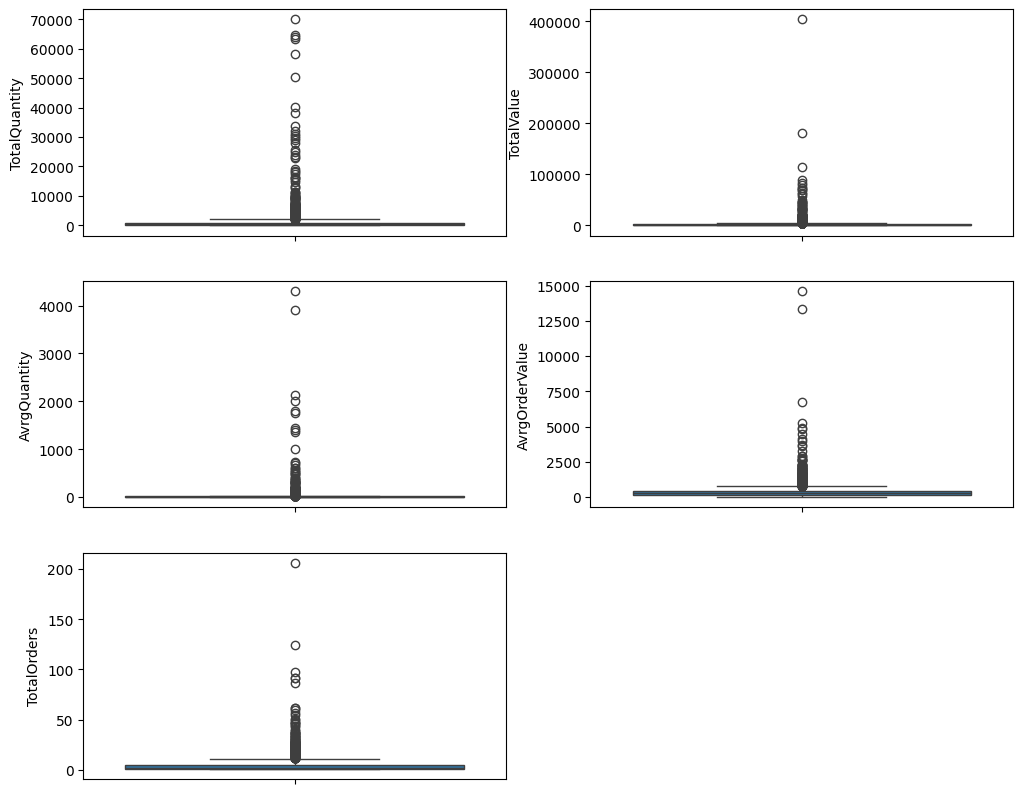

In [16]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

sns.boxplot(data=cust['TotalQuantity'], ax=ax[0, 0]) 
sns.boxplot(data=cust['TotalValue'], ax=ax[0, 1]) 
sns.boxplot(data=cust['AvrgQuantity'], ax=ax[1, 0]) 
sns.boxplot(data=cust['AvrgOrderValue'], ax=ax[1, 1]) 
sns.boxplot(data=cust['TotalOrders'], ax=ax[2, 0]) 

# Remove the empty subplot
fig.delaxes(ax[2, 1])

plt.show()

<Axes: ylabel='AvrgQuantity'>

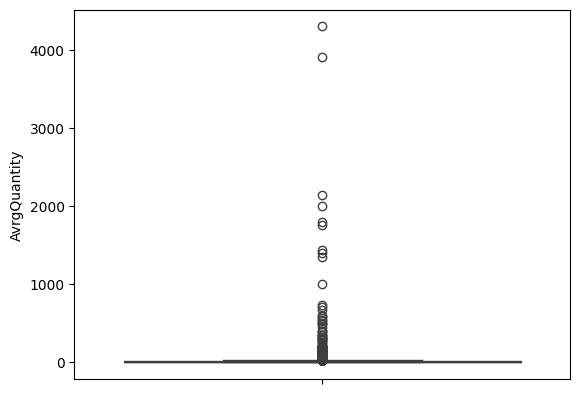

In [15]:
sns.boxplot(data = cust['AvrgQuantity']) 

<Axes: xlabel='AvrgQuantity', ylabel='AvrgOrderValue'>

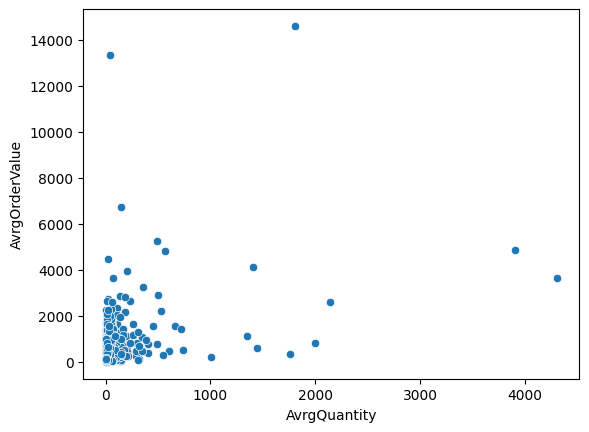

In [17]:
sns.scatterplot(data=cust, x='AvrgQuantity', y='AvrgOrderValue')

# Scaling data

*temp note from a linkedin article*

Normalization rescales your data to have values between 0 and 1, while standardization rescales your data to have a mean of 0 and a standard deviation of 1. You can use various methods to normalize or standardize your data, such as min-max scaling, z-score scaling, or log transformation.

has also more helpful info:
https://www.linkedin.com/advice/0/how-do-you-clean-your-data-before-clustering-skills-data-analysis#:~:text=Since%20clustering%20algorithms%20are%20sensitive,a%20standard%20deviation%20of%201.